# Project 3
# Malicious Traffic Detection: A machine learning based approach.

We sampled 10% of the original data from (Wang et al.) to reduce complexity, we controlled also controlled the sampling proccess to ensure the class balance of the original dataset was maintained.


### References

1. Scikit-learn. [Scikit-Learn: Machine Learning in Python — Scikit-Learn 0.20.3 Documentation](https://scikit-learn.org/stable/index.html). Scikit-Learn.org, 2019.

2. Wang, Zihao, et al. "Composed Encrypted Malicious Traffic Dataset for Machine Learning Based Encrypted Malicious Traffic Analysis." [Data on Mendeley](https://data.mendeley.com/datasets/ztyk4h3v6s/2), vol. 2, 12 Oct. 2021, DOI: 10.17632/ztyk4h3v6s.2.



### Group Members
- Shedrach Ezenwali  300377414
- Bryan Rodriguez    300369955
- Hazel Ibasco       300366644
- Nathaniel Pearson  300387657

____

____

## Library-import

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import time


In [48]:
df = pd.read_csv("./Dataset/Project_Dataset_small.csv")

In [49]:
## A look of the data set
df.head()

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput,source_IP_address,Destination_IP_address
0,36921,16,1726605254,0.000000,40,0,20,20,256,20,...,2612.754597,73.926902,73.926820,20.0,20.0,46460.0,220.000000,70.495085,172.16.0.1,192.168.10.50
1,70905,24,111406979,0.422222,90,38,32,20,349,70,...,652.289643,23.073098,23.085064,20.0,20.0,1847669.0,28.269231,4594.488163,192.168.1.191,172.217.23.227
2,16501,24,1708705887,0.633028,109,69,20,20,15544,89,...,494.028050,0.624303,0.310843,20.0,20.0,5206.0,33.000000,70.015643,10.42.0.151,198.11.189.2
3,43411,16,3715465867,0.973333,1500,1460,20,20,1892,1480,...,571.420643,3.462844,3.463654,20.0,20.0,15827.0,48.925000,152.105082,192.168.10.15,31.172.81.159
4,10855,24,2844819149,0.818182,286,234,32,20,939,266,...,338.609370,0.115753,0.126025,20.0,20.0,86828.0,28.846154,182.869865,10.42.0.42,104.97.137.75


In [50]:
## Let's get general information about the data, the shape and also the data type

def get_data_description(df)->None:
    '''Take a dataframe and prints out a consise 
    description based on the data shape'''
    rows,cols = df.shape

    print(f'We have {rows} rows and {cols} columns in the data set')

get_data_description(df)



We have 10476 rows and 113 columns in the data set


In [51]:
## Checking of the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Columns: 113 entries, session to Destination_IP_address
dtypes: float64(97), int64(14), object(2)
memory usage: 9.0+ MB


In [52]:
## Getting the percentage of missing values in each column

def check_cols_with_null(df):
    '''Gets  dataframe and prints out percentage of missing values in each column'''
    print(    df.shape)
    for col in df.columns:
        print(f'{col}: {format((df[col].isnull().sum()/df.shape[0])*100,".0f")}%')

check_cols_with_null(df)

(10476, 113)
session: 0%
Flag_of_packets: 0%
Traffic_sequence: 0%
Payload_ratio: 0%
Length_of_IP_packets: 0%
Length_of_TCP_payload: 0%
Length_of_TCP_packet_header: 0%
Length_of_IP_packet_header: 0%
TCP_windows_size_value: 0%
Length_of_TCP_segment(packet): 0%
Time_difference_between_packets_per_session: 0%
Change_values_of_TCP_windows_length_per_session: 0%
Interval_of_arrival_time_of_forward_traffic: 0%
Interval_of_arrival_time_of_backward_traffic: 0%
Time_to_live: 0%
Ratio_to_previous_packets_in_each_session: 0%
Total_length_of_IP_packet_per_session: 0%
Total_Time_to_live_per_session: 0%
The_times_of_change_of_TCP_windows_length: 0%
The_times_of_change_of_payload_per_session: 0%
Total_length_of_forward_payload: 0%
Total_length_of_backward_payload: 0%
Total_length_of_forward_IP_header: 0%
Total_length_of_backward_IP_header: 0%
Total_length_of_forward_TCP_header: 0%
Total_length_of_backward_TCP_header: 0%
Total_length_of_forward_IP_packets: 0%
Total_length_of_backward_IP_packets: 0%
flo

#### Categorical data such as source_IP_address and Destination_IP_address are not relevant.

In [53]:
# Removing categorical variables that are not considered important for the model 
df.drop(["source_IP_address","Destination_IP_address"],axis=1,inplace=True)

## Handling-non_valid-column-names

In [54]:
#columns to rename and their corresponding new names

columns_map = {
    "flow duration":"flow_duration"
}

df.rename(columns=columns_map,inplace = True)

## Creating-dummy-variables-for-each-categorical-feature

In [55]:
# Identify categorical features
categorical_columns = df.select_dtypes('object').columns

# Create dummy variables for each categorical feature
for column in categorical_columns:
    # Create dummy variables with a prefix related to the original column name
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    
    # Rename columns using lambda to replace hyphen '-' with underscore '_'
    dummies.columns = dummies.columns.map(lambda x: x.replace('-', '_'))
    
    # Concatenate the dummy variables to the original DataFrame
    df = pd.concat([df, dummies], axis=1)
    
# Drop the original categorical columns
df = df.drop(categorical_columns, axis=1)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Columns: 111 entries, session to Goodput
dtypes: float64(97), int64(14)
memory usage: 8.9 MB


## Exploratory analysis

In [57]:
#Looking at summary stastics
summary_stats = df.describe().transpose()
summary_stats

,count,mean,std,min,25%,50%,75%,max
session,10476.0,4.955364e+04,2.641171e+04,15.000000,2.757975e+04,5.064400e+04,7.226000e+04,9.408000e+04
Flag_of_packets,10476.0,2.102024e+01,4.375869e+00,2.000000,1.600000e+01,2.400000e+01,2.400000e+01,2.500000e+01
Traffic_sequence,10476.0,2.066422e+09,1.252283e+09,0.000000,9.746859e+08,2.028956e+09,3.165945e+09,4.294183e+09
Payload_ratio,10476.0,7.220713e-01,3.080842e-01,0.000000,5.398230e-01,8.414634e-01,9.653333e-01,9.965621e-01
Length_of_IP_packets,10476.0,7.129238e+02,9.461718e+02,40.000000,1.040000e+02,2.970000e+02,1.460000e+03,1.163500e+04
...,...,...,...,...,...,...,...,...
mean_of_backward_IP_header,10476.0,1.999809e+01,1.954035e-01,0.000000,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01
mean_of_forward_IP_header,10476.0,2.000000e+01,0.000000e+00,20.000000,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01
total_payload_per_session,10476.0,5.157129e+05,2.799799e+07,0.000000,1.033625e+04,2.883000e+04,5.807300e+04,2.502666e+09
IPratio,10476.0,6.143487e+01,7.223333e+01,1.153846,2.884615e+01,3.675000e+01,3.750000e+01,3.259231e+02


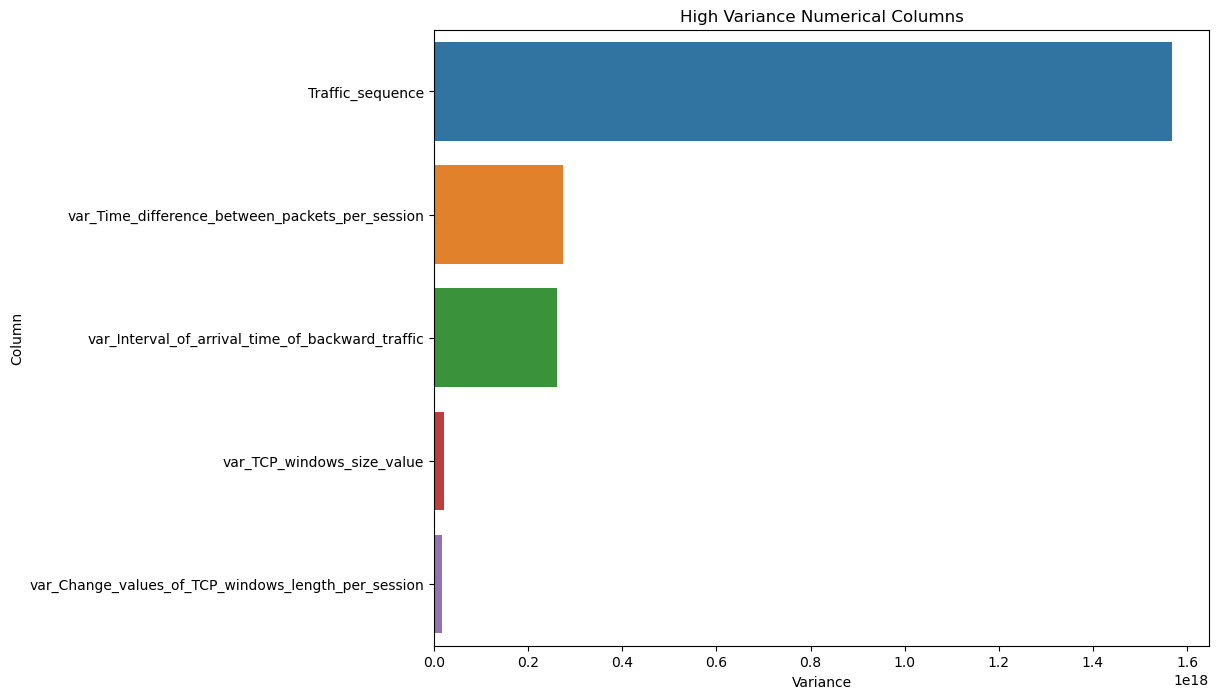

In [58]:
variance_df = df.var().reset_index()
variance_df.columns = ['Column', 'Variance']

# Set threshold to filter out all variance = 0 columns
threshold = variance_df['Variance'].quantile(0.96)

# Filter out columns with variance below the threshold
high_variance_df = variance_df[variance_df['Variance'] >= threshold]
high_variance_df = high_variance_df.sort_values(by='Variance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x='Variance', y='Column', data=high_variance_df, orient='h')
plt.title('High Variance Numerical Columns')
plt.show()

### Searching best correlation 

In [59]:
df.corr()

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,Source_port,std_forward_pkt_length,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput
session,1.000000,0.059464,-0.037602,0.162769,-0.004941,-0.005851,0.142884,NaN,0.139968,-0.004941,...,-0.248161,0.222545,-0.111225,0.144354,0.140728,-0.001890,NaN,0.019794,-0.169990,-0.054518
Flag_of_packets,0.059464,1.000000,0.002789,0.150440,-0.292459,-0.292334,-0.004379,NaN,0.002694,-0.292459,...,-0.164167,0.048958,-0.383781,0.055365,0.048452,-0.006654,NaN,0.006172,-0.411071,-0.026558
Traffic_sequence,-0.037602,0.002789,1.000000,-0.033481,-0.011656,-0.012062,0.064371,NaN,-0.143630,-0.011656,...,-0.040963,0.012430,0.031754,0.019184,0.019051,-0.000954,NaN,-0.006648,0.031787,-0.011798
Payload_ratio,0.162769,0.150440,-0.033481,1.000000,0.522375,0.521957,0.038307,NaN,0.086147,0.522375,...,-0.107874,0.241276,-0.571227,0.071431,0.064390,-0.004363,NaN,0.006813,-0.595862,0.072126
Length_of_IP_packets,-0.004941,-0.292459,-0.011656,0.522375,1.000000,0.999980,-0.048959,NaN,-0.031455,1.000000,...,0.071739,0.062577,0.066651,-0.032581,-0.030067,0.004419,NaN,-0.001637,0.074318,0.050442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mean_of_backward_IP_header,-0.001890,-0.006654,-0.000954,-0.004363,0.004419,0.004357,0.009527,NaN,0.005247,0.004419,...,0.016757,-0.014598,0.009431,0.002651,0.002601,1.000000,NaN,0.000177,0.003238,0.001505
mean_of_forward_IP_header,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_payload_per_session,0.019794,0.006172,-0.006648,0.006813,-0.001637,-0.001736,0.015614,NaN,-0.006204,-0.001637,...,0.005043,0.015254,-0.012890,-0.004811,-0.004716,0.000177,NaN,1.000000,0.001105,0.018877
IPratio,-0.169990,-0.411071,0.031787,-0.595862,0.074318,0.075752,-0.228673,NaN,-0.127978,0.074318,...,0.297500,-0.258909,0.899821,-0.095984,-0.086327,0.003238,NaN,0.001105,1.000000,-0.042925


In [60]:
correlation_matrix = df.corr()

In [61]:
# Example: Find pairs with correlation above 0.7
strong_correlations = correlation_matrix[abs(correlation_matrix) > 0.7]

In [62]:
strong_correlations

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,Source_port,std_forward_pkt_length,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput
session,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flag_of_packets,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Traffic_sequence,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Payload_ratio,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length_of_IP_packets,NaN,NaN,NaN,NaN,1.0,0.99998,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mean_of_backward_IP_header,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
mean_of_forward_IP_header,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_payload_per_session,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
IPratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.899821,NaN,NaN,NaN,NaN,NaN,1.0,NaN


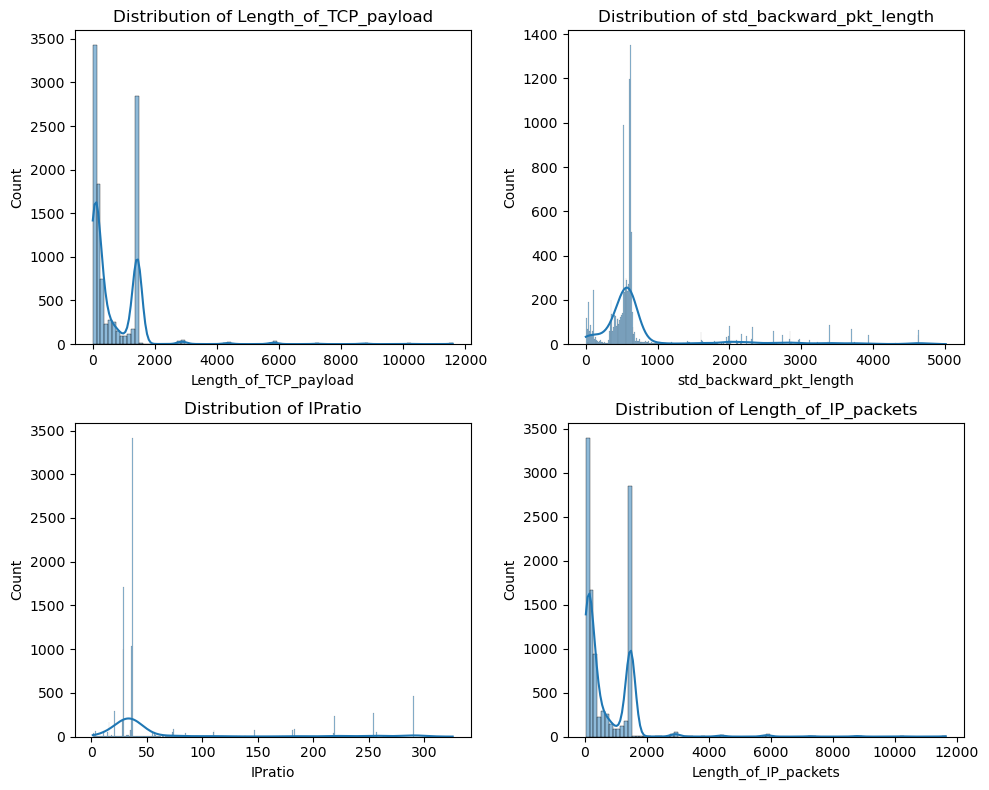

In [63]:
#Visualize the distribution of some high correlation variables
selected_columns = df[["Length_of_TCP_payload", "std_backward_pkt_length", "IPratio", "Length_of_IP_packets"]]

#Grid Layout
num_plots = selected_columns.shape[1]
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
axes = axes.flatten()

#loop
for i, column in enumerate(selected_columns.columns):
    sns.histplot(selected_columns[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

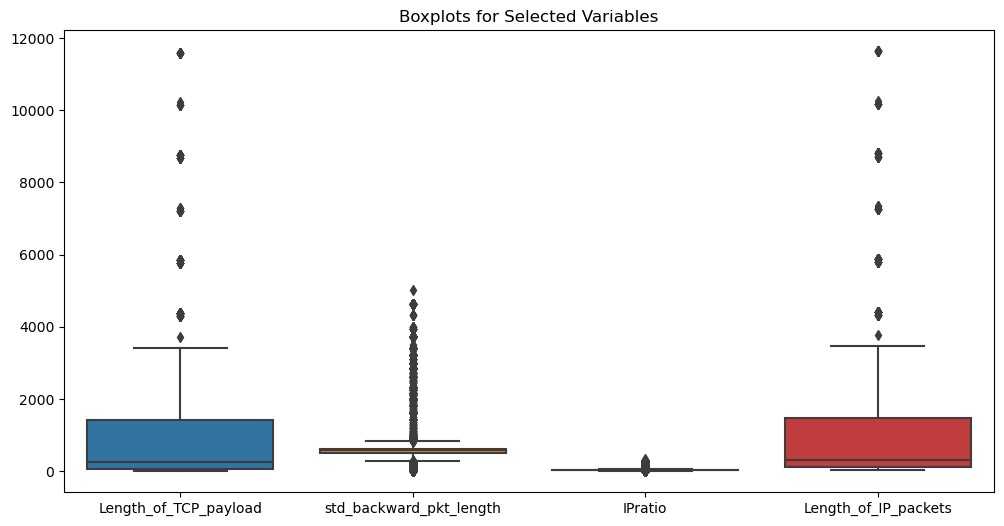

In [64]:
#boxtplot of high correlation variables
subset_of_variables = df[["Length_of_TCP_payload", "std_backward_pkt_length", "IPratio", "Length_of_IP_packets"]]  # Add variables of interest
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_of_variables, orient='v')
plt.title('Boxplots for Selected Variables')
plt.show()

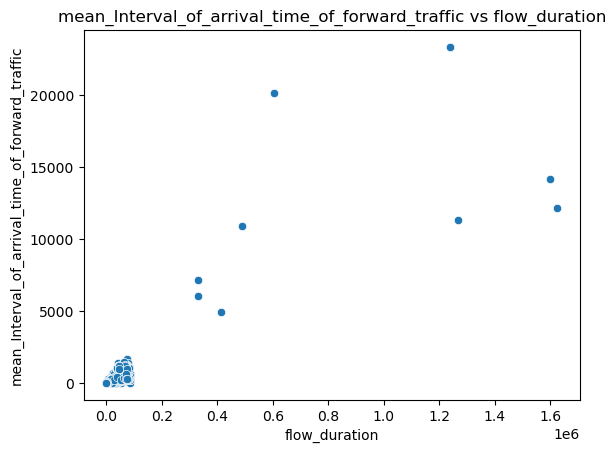

In [65]:
## let's see data

sns.scatterplot(x=df.flow_duration,y=df.mean_Interval_of_arrival_time_of_forward_traffic)

plt.title("mean_Interval_of_arrival_time_of_forward_traffic vs flow_duration")

plt.show()

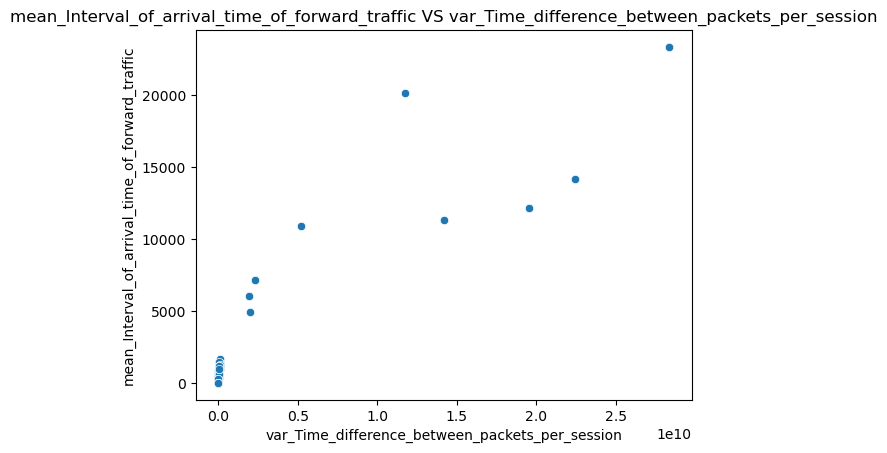

In [66]:
## let's see data

sns.scatterplot(x=df.var_Time_difference_between_packets_per_session,y=df.mean_Interval_of_arrival_time_of_forward_traffic)

plt.title("mean_Interval_of_arrival_time_of_forward_traffic VS var_Time_difference_between_packets_per_session")

plt.show()

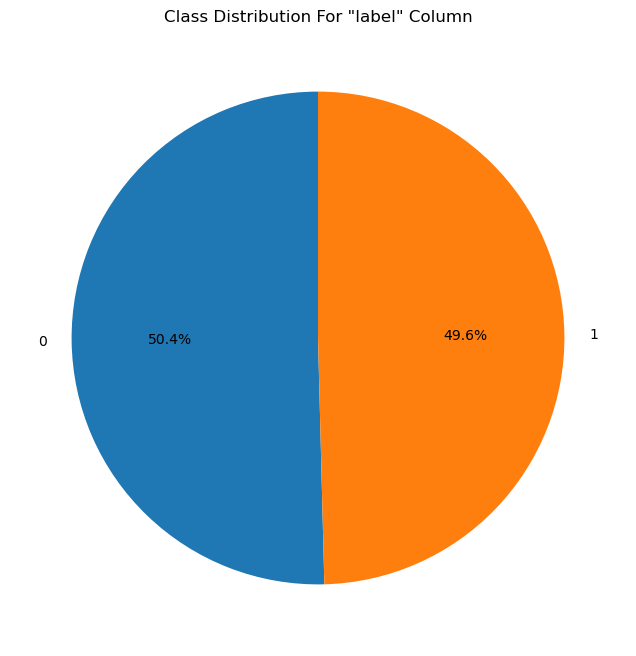

In [67]:
# Assuming df is your DataFrame and 'target_column' is the target variable
class_distribution = df['label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution For "label" Column')
plt.show()

___

## Feature-Selection-and-Scaling / Model Training and Evaluation:

#### As we have a type of high-dimensional data sets and they are all used for the creation of Machine Learning models, it can cause:

          * The additional features act as noise for which the Machine Learning model can perform extremely poorly.
          * The model takes longer to train.
          * Allocation of unnecessary resources for these features.

For all this, feature selection must be implemented in Machine Learning projects.

In [68]:
# Example: Predict 'label' using other features
##Separate features (X_selected) and the target variable (Y_selected):
X = df.drop('label', axis=1)  # Assuming 'label' is the target variable
y = df['label']

In [69]:
#Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
kfold = KFold(n_splits=5,random_state=1024,shuffle=True)

In [71]:
# feature selection methods
feature_selection_methods = [
    ('RandomForest_Feature_selection', SelectFromModel(estimator = RandomForestClassifier(random_state=0,max_depth=3,n_estimators=10))),
    ('Kbest_Feature_selection', SelectKBest(mutual_info_classif, k='all')),
]

# Scaling methods
scaling_methods = [
    ('RobustScaler', RobustScaler()),
]

# classifiers and their respective parameter grids
classifiers = [
    ('GaussianNB', GaussianNB(),{}),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=3),{}),
    ('Random Forest', RandomForestClassifier(random_state=0),{'classifier__max_depth': [5,10]}),
]

In [72]:
# Create a list of all pipelines to be evaluated
pipelines = []
for scaler_name, scaler in scaling_methods:
    for feature_selection_name,feature_selection in feature_selection_methods:
        for clf_name, clf,param_grid_classfier in classifiers:
            steps = [('feature_selection', feature_selection),('scaler', scaler), ('classifier', clf)]
            pipelines.append((f'{feature_selection_name} + {scaler_name} + {clf_name}', Pipeline(steps), {**param_grid_classfier}))

In [73]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all warnings
warnings.filterwarnings("ignore",category=ConvergenceWarning)

model_name = []
model_score = []
best_params = {}
estimators: dict[str,Pipeline] = {}

for name,pipeline,param_grid in pipelines:
    
    gridSearch = GridSearchCV (
    estimator = pipeline,
    param_grid = param_grid,
    n_jobs=-1,
    scoring='accuracy',
    cv=kfold,
    verbose=0
    )
    
    gridSearch.fit(X_train,y_train)

    model_score.append(gridSearch.best_score_)
    model_name.append(name)
    best_params[name] = gridSearch.best_params_
    estimators[name] = gridSearch.best_estimator_

/Users/shedinho/miniconda3/envs/flight_delay-env/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [74]:
models = pd.DataFrame({"name":model_name,"score":model_score})

models

,name,score
0,RandomForest_Feature_selection + RobustScaler ...,0.518616
1,RandomForest_Feature_selection + RobustScaler ...,0.861098
2,RandomForest_Feature_selection + RobustScaler ...,0.988663
3,Kbest_Feature_selection + RobustScaler + Gauss...,0.508950
4,Kbest_Feature_selection + RobustScaler + K-Nea...,0.820048
5,Kbest_Feature_selection + RobustScaler + Rando...,0.983055


In [75]:
selected_model_name = models[models.score  == max(models.score)].iloc[0,0]

selected_model_name

'RandomForest_Feature_selection + RobustScaler + Random Forest'

In [76]:
selected_model = estimators[selected_model_name]

selected_model

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(max_depth=3,
                                                                  n_estimators=10,
                                                                  random_state=0))),
                ('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, random_state=0))])

In [77]:
print(f"{len(X.columns[selected_model.named_steps['feature_selection'].get_support()])} columns was selected")

27 columns was selected


In [78]:
##Make predictions and evaluate the model:
y_pred = selected_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9885496183206107


### Classification Report 

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1065
           1       1.00      0.98      0.99      1031

    accuracy                           0.99      2096
   macro avg       0.99      0.99      0.99      2096
weighted avg       0.99      0.99      0.99      2096



    The accuracy of the model making True 'label' is very high judging from the precision (1) and recall (0.98). 

In [80]:
confusion_mat = confusion_matrix(y_test, y_pred)

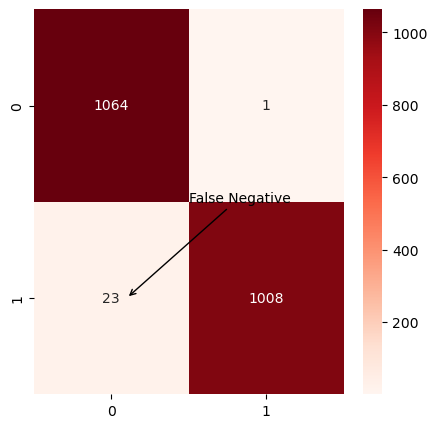

In [81]:
plt.figure(figsize = (5,5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.annotate('False Negative', xy=(0.6, 1.5), xytext=(1, 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
sns.heatmap(confusion_mat,cmap="Reds",annot=True,fmt="d")

plt.show()

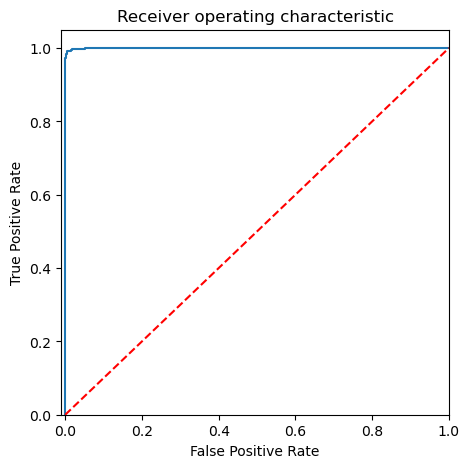

In [82]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, selected_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.show()

#### The current accuracy of our prediction model is acceptable; however, we aim to improve it further by merging the selected model with other performers from the search. Our objective is to create an Ensemble model (soft vote) which will be evaluated to determine if it can reduce the count of 23 False Negative instances, while maintaining a low likelihood of a malicious attack.

## Ensemble model

In [83]:
#sort model dataframe in desc order to get the top two also buttom

top2_models = list(models.sort_values("score",ascending=False).name[:2])
buttom_model = list(models.sort_values("score").name[:1])

models_selected = top2_models + buttom_model

models_selected

['RandomForest_Feature_selection + RobustScaler + Random Forest',
 'Kbest_Feature_selection + RobustScaler + Random Forest',
 'Kbest_Feature_selection + RobustScaler + GaussianNB']

In [84]:
estimators_soft_voting = []

for model_name in models_selected:
   estimators_soft_voting.append((model_name,estimators[model_name]))

In [85]:
vh_clf = VotingClassifier(
    estimators=estimators_soft_voting,
    voting="soft"
)
vh_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('RandomForest_Feature_selection + RobustScaler + '
                              'Random Forest',
                              Pipeline(steps=[('feature_selection',
                                               SelectFromModel(estimator=RandomForestClassifier(max_depth=3,
                                                                                                n_estimators=10,
                                                                                                random_state=0))),
                                              ('scaler', RobustScaler()),
                                              ('classifier',
                                               RandomForestClassifier(max_depth=10,
                                                                      random_state=0))])),
                             ('Kbest_Feature_selection + Robus...
                                                           score_func=<function mutual_info_classif at 0x134d391c0>)),
                                              ('scaler', RobustScaler()),
                                              ('classifier',
                                               RandomForestClassifier(max_depth=10,
                                                                      random_state=0))])),
                             ('Kbest_Feature_selection + RobustScaler + '
                              'GaussianNB',
                              Pipeline(steps=[('feature_selection',
                                               SelectKBest(k='all',
                                                           score_func=<function mutual_info_classif at 0x134d391c0>)),
                                              ('scaler', RobustScaler()),
                                              ('classifier', GaussianNB())]))],
                 voting='soft')

In [86]:
y_predic = vh_clf.predict(X_test)

print(f"accuracy_score soft voting {accuracy_score(y_test,y_predic)}")

accuracy_score soft voting 0.9766221374045801


In [87]:
confusion_mat = confusion_matrix(y_test, y_predic)

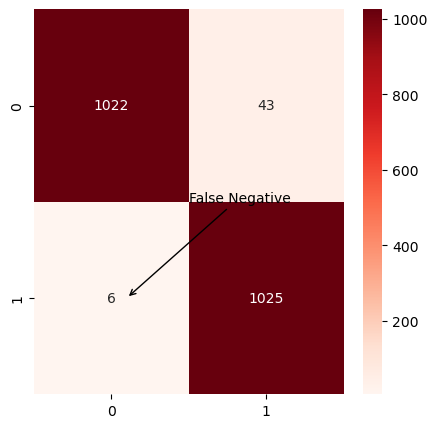

In [88]:
plt.figure(figsize = (5,5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.annotate('False Negative', xy=(0.6, 1.5), xytext=(1, 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
sns.heatmap(confusion_mat,cmap="Reds",annot=True,fmt="d")

plt.show()

#### According to the latest evaluation report, the Ensemble method has an accuracy score of 0.97, which is slightly lower than the previous model. However, considering the business logic and the need to protect the server from malicious traffic, we prioritize the ability to detect as much of such traffic as possible. For this reason, we propose this model as a preferable approach since False Negative is 6 and True Positive is 1023

### Out-of-sample Predictions

In [50]:
df_new = pd.read_csv("./Dataset/Project_Dataset_test.csv")

y_predic_new = vh_clf.predict(df_new)

print(y_predic_new)

[0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1]


# Member Contribution 

| Evaluator/Evaluatee |Shedrach Ezenwali   | Bryan Rodriguez | Hazel Ibasco | Nathaniel Pearson|
|------|------| ------| ------| ------|
| Shedrach Ezenwali | - | 4 | 4 |  4|
| Bryan Rodriguez | 4 | - | 4 | 4 | 
| Hazel Ibasco |  |  | -  | |
| Nathaniel Pearson | | | | - |

____